# Prediction of NBA Win/Loss using Neural Networks


Lets first load required libraries:

In [133]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import initializers
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

Lets download the dataset

In [134]:
cnxn = pyodbc.connect(r'Driver={SQL Server};Server=localhost;Database=nba;Trusted_Connection=yes;')
sql = "select * from Game_Stats"
df1 = pd.read_sql(sql, cnxn)

### Find the number of records

In [135]:
df1.shape

(23096, 21)

### Lets look at the columns

### Attributes: (all numeric-valued)
   1. Field goal percentage for home team
   2. Free throw percentage for home team
   3. 3pt Field goal percentage for home team
   4. Assists for home team
   5. Rebounds for home team
   6. Field goal percentage for away team
   7. Assists for away team
   8. Rebounds for away team
   9. Win or Loss (1 or 0)

In [136]:
df1.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,1/3/2020,21900895,Final,1610612766,1610612749,2019,1610612766,85,0.354,0.900,...,22,47,1610612749,93,0.402,0.762,0.226,20,61,0
1,1/3/2020,21900896,Final,1610612750,1610612742,2019,1610612750,91,0.364,0.400,...,19,57,1610612742,111,0.468,0.632,0.275,28,56,0
2,1/3/2020,21900897,Final,1610612746,1610612755,2019,1610612746,136,0.592,0.805,...,25,37,1610612755,130,0.505,0.650,0.488,27,37,1
3,1/3/2020,21900898,Final,1610612743,1610612761,2019,1610612743,133,0.566,0.700,...,38,41,1610612761,118,0.461,0.897,0.263,24,36,1
4,1/3/2020,21900899,Final,1610612758,1610612765,2019,1610612758,106,0.407,0.885,...,18,51,1610612765,100,0.413,0.667,0.429,23,42,1


### Find the features and split the data into train and test

In [137]:
X = df1[['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'FG_PCT_away','AST_away', 'REB_away']]
y = df1['HOME_TEAM_WINS']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

### Train a RandomForest model as a Baseline

In [138]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [139]:
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.830
roc-auc is 0.910


### Train a Neural Network model with one hidden layer with sigmoid activation

In [140]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [141]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6842 - accuracy: 0.5934 - val_loss: 0.6201 - val_accuracy: 0.6437
Epoch 2/50
578/578 [==============================] - 2s 4ms/step - loss: 0.6056 - accuracy: 0.7009 - val_loss: 0.5957 - val_accuracy: 0.7227
Epoch 3/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5882 - accuracy: 0.7271 - val_loss: 0.5788 - val_accuracy: 0.7247
Epoch 4/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5760 - accuracy: 0.7337 - val_loss: 0.5674 - val_accuracy: 0.7307
Epoch 5/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5663 - accuracy: 0.7393 - val_loss: 0.5603 - val_accuracy: 0.7338
Epoch 6/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5584 - accuracy: 0.7401 - val_loss: 0.5545 - val_accuracy: 0.7338
Epoch 7/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5523 - accuracy: 0.7422 - val_loss: 0.5497 - val_accuracy: 0.7361
Epoch 

In [142]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

In [143]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.744
roc-auc is 0.815


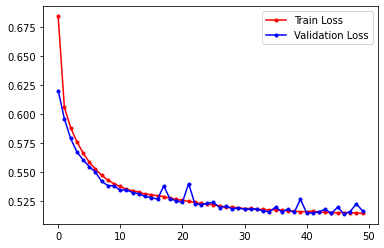

In [144]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Add two hidden layers to the Neural Networks

In [145]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(12,activation='sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_52 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [146]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6852 - accuracy: 0.5913 - val_loss: 0.6715 - val_accuracy: 0.6093
Epoch 2/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6779 - accuracy: 0.5913 - val_loss: 0.6706 - val_accuracy: 0.6093
Epoch 3/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6769 - accuracy: 0.5913 - val_loss: 0.6700 - val_accuracy: 0.6093
Epoch 4/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6763 - accuracy: 0.5913 - val_loss: 0.6695 - val_accuracy: 0.6093
Epoch 5/50
578/578 [==============================] - 2s 3ms/step - loss: 0.6757 - accuracy: 0.5913 - val_loss: 0.6684 - val_accuracy: 0.6093
Epoch 6/50
578/578 [==============================] - 1s 3ms/step - loss: 0.6744 - accuracy: 0.5913 - val_loss: 0.6668 - val_accuracy: 0.6093
Epoch 7/50
578/578 [==============================] - 1s 2ms/step - loss: 0.6715 - accuracy: 0.5913 - val_loss: 0.6630 - val_accuracy: 0.6093
Epoch 

In [147]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.742
roc-auc is 0.817


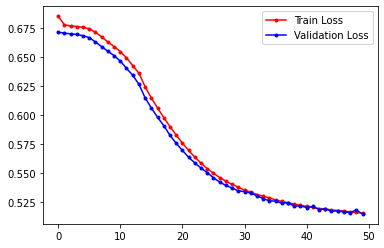

In [148]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Change to two hidden layers with activation relu

In [149]:
model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'relu'))
model_1.add(Dense(12,activation='relu'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_55 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [150]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
578/578 [==============================] - 2s 4ms/step - loss: 0.5783 - accuracy: 0.7044 - val_loss: 0.6210 - val_accuracy: 0.6708
Epoch 2/50
578/578 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7317 - val_loss: 0.5453 - val_accuracy: 0.7234
Epoch 3/50
578/578 [==============================] - 2s 3ms/step - loss: 0.5207 - accuracy: 0.7386 - val_loss: 0.5101 - val_accuracy: 0.7431
Epoch 4/50
578/578 [==============================] - 2s 3ms/step - loss: 0.5156 - accuracy: 0.7384 - val_loss: 0.5126 - val_accuracy: 0.7413
Epoch 5/50
578/578 [==============================] - 2s 3ms/step - loss: 0.5141 - accuracy: 0.7407 - val_loss: 0.5161 - val_accuracy: 0.7368
Epoch 6/50
578/578 [==============================] - 2s 3ms/step - loss: 0.5118 - accuracy: 0.7430 - val_loss: 0.5031 - val_accuracy: 0.7452
Epoch 7/50
578/578 [==============================] - 2s 3ms/step - loss: 0.5129 - accuracy: 0.7437 - val_loss: 0.5151 - val_accuracy: 0.7392
Epoch 

In [151]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.742
roc-auc is 0.819


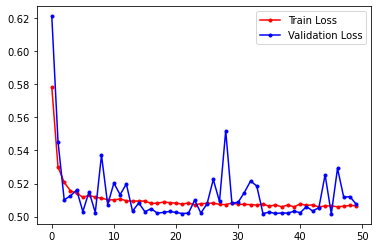

In [152]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

### Change to epochs 1000

In [153]:
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)

Epoch 1/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5067 - accuracy: 0.7458 - val_loss: 0.5023 - val_accuracy: 0.7457
Epoch 2/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.5062 - accuracy: 0.7466 - val_loss: 0.5027 - val_accuracy: 0.7459
Epoch 3/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.5064 - accuracy: 0.7467 - val_loss: 0.5072 - val_accuracy: 0.7424
Epoch 4/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5066 - accuracy: 0.7458 - val_loss: 0.5050 - val_accuracy: 0.7455
Epoch 5/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5064 - accuracy: 0.7459 - val_loss: 0.5083 - val_accuracy: 0.7403
Epoch 6/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5057 - accuracy: 0.7453 - val_loss: 0.5095 - val_accuracy: 0.7405
Epoch 7/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5060 - accuracy: 0.7463 - val_loss: 0.5078 - val_accuracy:

578/578 [==============================] - 2s 3ms/step - loss: 0.5042 - accuracy: 0.7466 - val_loss: 0.4989 - val_accuracy: 0.7476
Epoch 58/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5039 - accuracy: 0.7485 - val_loss: 0.5030 - val_accuracy: 0.7439
Epoch 59/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5039 - accuracy: 0.7457 - val_loss: 0.5179 - val_accuracy: 0.7340
Epoch 60/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.5039 - accuracy: 0.7489 - val_loss: 0.4989 - val_accuracy: 0.7478
Epoch 61/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5036 - accuracy: 0.7474 - val_loss: 0.4994 - val_accuracy: 0.7476
Epoch 62/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5043 - accuracy: 0.7445 - val_loss: 0.5276 - val_accuracy: 0.7268
Epoch 63/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5036 - accuracy: 0.7468 - val_loss: 0.4995 - val_accuracy: 0.7489

578/578 [==============================] - 2s 3ms/step - loss: 0.5028 - accuracy: 0.7476 - val_loss: 0.5010 - val_accuracy: 0.7459
Epoch 114/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5020 - accuracy: 0.7480 - val_loss: 0.4985 - val_accuracy: 0.7494
Epoch 115/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5019 - accuracy: 0.7485 - val_loss: 0.4976 - val_accuracy: 0.7487
Epoch 116/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5021 - accuracy: 0.7482 - val_loss: 0.5016 - val_accuracy: 0.7444
Epoch 117/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5024 - accuracy: 0.7469 - val_loss: 0.4975 - val_accuracy: 0.7474
Epoch 118/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5027 - accuracy: 0.7488 - val_loss: 0.5034 - val_accuracy: 0.7444
Epoch 119/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5024 - accuracy: 0.7490 - val_loss: 0.4994 - val_accuracy: 

578/578 [==============================] - 1s 3ms/step - loss: 0.5005 - accuracy: 0.7469 - val_loss: 0.5103 - val_accuracy: 0.7405
Epoch 170/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5005 - accuracy: 0.7492 - val_loss: 0.4995 - val_accuracy: 0.7450
Epoch 171/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5006 - accuracy: 0.7491 - val_loss: 0.4947 - val_accuracy: 0.7498
Epoch 172/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5011 - accuracy: 0.7484 - val_loss: 0.4949 - val_accuracy: 0.7498
Epoch 173/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.5009 - accuracy: 0.7496 - val_loss: 0.4949 - val_accuracy: 0.7511
Epoch 174/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4997 - accuracy: 0.7499 - val_loss: 0.5014 - val_accuracy: 0.7478
Epoch 175/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.5002 - accuracy: 0.7497 - val_loss: 0.4950 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.7509 - val_loss: 0.4915 - val_accuracy: 0.7532
Epoch 226/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4991 - accuracy: 0.7503 - val_loss: 0.5154 - val_accuracy: 0.7320
Epoch 227/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4990 - accuracy: 0.7484 - val_loss: 0.5048 - val_accuracy: 0.7433
Epoch 228/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4984 - accuracy: 0.7525 - val_loss: 0.4936 - val_accuracy: 0.7506
Epoch 229/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4985 - accuracy: 0.7530 - val_loss: 0.4923 - val_accuracy: 0.7519
Epoch 230/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4985 - accuracy: 0.7533 - val_loss: 0.4940 - val_accuracy: 0.7515
Epoch 231/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4987 - accuracy: 0.7498 - val_loss: 0.5181 - val_accuracy: 

578/578 [==============================] - 2s 4ms/step - loss: 0.4960 - accuracy: 0.7528 - val_loss: 0.5004 - val_accuracy: 0.7476
Epoch 282/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4960 - accuracy: 0.7555 - val_loss: 0.4865 - val_accuracy: 0.7567
Epoch 283/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4967 - accuracy: 0.7540 - val_loss: 0.4880 - val_accuracy: 0.7535
Epoch 284/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4964 - accuracy: 0.7521 - val_loss: 0.4856 - val_accuracy: 0.7576
Epoch 285/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4956 - accuracy: 0.7540 - val_loss: 0.4918 - val_accuracy: 0.7532
Epoch 286/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4968 - accuracy: 0.7534 - val_loss: 0.4870 - val_accuracy: 0.7554
Epoch 287/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4961 - accuracy: 0.7525 - val_loss: 0.4935 - val_accuracy: 

578/578 [==============================] - 2s 3ms/step - loss: 0.4949 - accuracy: 0.7536 - val_loss: 0.4850 - val_accuracy: 0.7567
Epoch 338/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4929 - accuracy: 0.7540 - val_loss: 0.4918 - val_accuracy: 0.7494
Epoch 339/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4938 - accuracy: 0.7544 - val_loss: 0.4838 - val_accuracy: 0.7571
Epoch 340/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4927 - accuracy: 0.7557 - val_loss: 0.4805 - val_accuracy: 0.7604
Epoch 341/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4938 - accuracy: 0.7535 - val_loss: 0.4813 - val_accuracy: 0.7634
Epoch 342/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4920 - accuracy: 0.7573 - val_loss: 0.5382 - val_accuracy: 0.7229
Epoch 343/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4936 - accuracy: 0.7548 - val_loss: 0.5183 - val_accuracy: 

578/578 [==============================] - 2s 3ms/step - loss: 0.4888 - accuracy: 0.7559 - val_loss: 0.4769 - val_accuracy: 0.7652
Epoch 394/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4919 - accuracy: 0.7573 - val_loss: 0.4796 - val_accuracy: 0.7619
Epoch 395/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4914 - accuracy: 0.7552 - val_loss: 0.4822 - val_accuracy: 0.7604
Epoch 396/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4911 - accuracy: 0.7571 - val_loss: 0.4757 - val_accuracy: 0.7643
Epoch 397/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4893 - accuracy: 0.7564 - val_loss: 0.4811 - val_accuracy: 0.7580
Epoch 398/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4914 - accuracy: 0.7564 - val_loss: 0.4752 - val_accuracy: 0.7632
Epoch 399/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4904 - accuracy: 0.7559 - val_loss: 0.5029 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4866 - accuracy: 0.7601 - val_loss: 0.4977 - val_accuracy: 0.7463
Epoch 450/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4891 - accuracy: 0.7582 - val_loss: 0.4713 - val_accuracy: 0.7647
Epoch 451/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4891 - accuracy: 0.7572 - val_loss: 0.4718 - val_accuracy: 0.7669
Epoch 452/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4887 - accuracy: 0.7585 - val_loss: 0.4733 - val_accuracy: 0.7677
Epoch 453/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4868 - accuracy: 0.7590 - val_loss: 0.4710 - val_accuracy: 0.7645
Epoch 454/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4871 - accuracy: 0.7575 - val_loss: 0.4828 - val_accuracy: 0.7545
Epoch 455/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4870 - accuracy: 0.7580 - val_loss: 0.4789 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4870 - accuracy: 0.7595 - val_loss: 0.4756 - val_accuracy: 0.7604
Epoch 506/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4854 - accuracy: 0.7593 - val_loss: 0.4895 - val_accuracy: 0.7500
Epoch 507/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4844 - accuracy: 0.7607 - val_loss: 0.4714 - val_accuracy: 0.7708
Epoch 508/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4866 - accuracy: 0.7594 - val_loss: 0.4823 - val_accuracy: 0.7584
Epoch 509/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4867 - accuracy: 0.7585 - val_loss: 0.4673 - val_accuracy: 0.7732
Epoch 510/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4852 - accuracy: 0.7591 - val_loss: 0.4716 - val_accuracy: 0.7682
Epoch 511/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.7619 - val_loss: 0.4898 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4801 - accuracy: 0.7624 - val_loss: 0.4611 - val_accuracy: 0.7758
Epoch 562/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4784 - accuracy: 0.7643 - val_loss: 0.4619 - val_accuracy: 0.7701
Epoch 563/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4845 - accuracy: 0.7617 - val_loss: 0.6357 - val_accuracy: 0.6929
Epoch 564/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4813 - accuracy: 0.7622 - val_loss: 0.4652 - val_accuracy: 0.7755
Epoch 565/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4853 - accuracy: 0.7588 - val_loss: 0.6343 - val_accuracy: 0.6881
Epoch 566/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4809 - accuracy: 0.7641 - val_loss: 0.4671 - val_accuracy: 0.7699
Epoch 567/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4834 - accuracy: 0.7610 - val_loss: 0.5252 - val_accuracy: 

578/578 [==============================] - 2s 4ms/step - loss: 0.4802 - accuracy: 0.7654 - val_loss: 0.4651 - val_accuracy: 0.7649
Epoch 618/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4809 - accuracy: 0.7634 - val_loss: 0.4977 - val_accuracy: 0.7452
Epoch 619/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4803 - accuracy: 0.7619 - val_loss: 0.4579 - val_accuracy: 0.7738
Epoch 620/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4806 - accuracy: 0.7661 - val_loss: 0.5343 - val_accuracy: 0.7268
Epoch 621/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4791 - accuracy: 0.7648 - val_loss: 0.4568 - val_accuracy: 0.7775
Epoch 622/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4772 - accuracy: 0.7654 - val_loss: 0.4734 - val_accuracy: 0.7632
Epoch 623/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4808 - accuracy: 0.7611 - val_loss: 0.4563 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4767 - accuracy: 0.7650 - val_loss: 0.4907 - val_accuracy: 0.7558
Epoch 674/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4786 - accuracy: 0.7636 - val_loss: 0.4574 - val_accuracy: 0.7794
Epoch 675/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4770 - accuracy: 0.7688 - val_loss: 0.4886 - val_accuracy: 0.7541
Epoch 676/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4757 - accuracy: 0.7665 - val_loss: 0.7149 - val_accuracy: 0.6732
Epoch 677/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4760 - accuracy: 0.7689 - val_loss: 0.4708 - val_accuracy: 0.7686
Epoch 678/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.7676 - val_loss: 0.5664 - val_accuracy: 0.7091
Epoch 679/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.7626 - val_loss: 0.5321 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4754 - accuracy: 0.7671 - val_loss: 0.4912 - val_accuracy: 0.7537
Epoch 730/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4732 - accuracy: 0.7678 - val_loss: 0.4566 - val_accuracy: 0.7790
Epoch 731/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4759 - accuracy: 0.7643 - val_loss: 0.6131 - val_accuracy: 0.6974
Epoch 732/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4760 - accuracy: 0.7650 - val_loss: 0.7054 - val_accuracy: 0.6262
Epoch 733/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4757 - accuracy: 0.7701 - val_loss: 0.4893 - val_accuracy: 0.7463
Epoch 734/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4756 - accuracy: 0.7669 - val_loss: 0.5357 - val_accuracy: 0.7281
Epoch 735/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4745 - accuracy: 0.7650 - val_loss: 0.4555 - val_accuracy: 

578/578 [==============================] - 2s 4ms/step - loss: 0.4736 - accuracy: 0.7656 - val_loss: 0.4643 - val_accuracy: 0.7742
Epoch 786/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4763 - accuracy: 0.7642 - val_loss: 0.4753 - val_accuracy: 0.7658
Epoch 787/1000
578/578 [==============================] - 2s 4ms/step - loss: 0.4722 - accuracy: 0.7704 - val_loss: 0.4849 - val_accuracy: 0.7481
Epoch 788/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.4721 - accuracy: 0.7692 - val_loss: 0.4713 - val_accuracy: 0.7617
Epoch 789/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4707 - accuracy: 0.7693 - val_loss: 0.6008 - val_accuracy: 0.6881
Epoch 790/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.4718 - accuracy: 0.7693 - val_loss: 0.4447 - val_accuracy: 0.7833
Epoch 791/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4730 - accuracy: 0.7663 - val_loss: 0.4927 - val_accuracy: 

578/578 [==============================] - 2s 3ms/step - loss: 0.4703 - accuracy: 0.7680 - val_loss: 0.4460 - val_accuracy: 0.7784
Epoch 842/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4708 - accuracy: 0.7683 - val_loss: 0.4688 - val_accuracy: 0.7716
Epoch 843/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.4696 - accuracy: 0.7688 - val_loss: 0.4964 - val_accuracy: 0.7435
Epoch 844/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.7680 - val_loss: 0.4437 - val_accuracy: 0.7827
Epoch 845/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4710 - accuracy: 0.7695 - val_loss: 0.4895 - val_accuracy: 0.7539
Epoch 846/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4699 - accuracy: 0.7683 - val_loss: 0.4504 - val_accuracy: 0.7742
Epoch 847/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4721 - accuracy: 0.7682 - val_loss: 0.5504 - val_accuracy: 

578/578 [==============================] - 1s 2ms/step - loss: 0.4681 - accuracy: 0.7686 - val_loss: 0.4499 - val_accuracy: 0.7751
Epoch 898/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4712 - accuracy: 0.7709 - val_loss: 0.4438 - val_accuracy: 0.7881
Epoch 899/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4679 - accuracy: 0.7704 - val_loss: 0.4895 - val_accuracy: 0.7457
Epoch 900/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4698 - accuracy: 0.7709 - val_loss: 0.6197 - val_accuracy: 0.6762
Epoch 901/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.7746 - val_loss: 0.4768 - val_accuracy: 0.7545
Epoch 902/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4648 - accuracy: 0.7727 - val_loss: 0.4847 - val_accuracy: 0.7494
Epoch 903/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4690 - accuracy: 0.7705 - val_loss: 0.4469 - val_accuracy: 

578/578 [==============================] - 1s 3ms/step - loss: 0.4672 - accuracy: 0.7689 - val_loss: 0.5335 - val_accuracy: 0.7253
Epoch 954/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4659 - accuracy: 0.7734 - val_loss: 0.5581 - val_accuracy: 0.7093
Epoch 955/1000
578/578 [==============================] - 1s 2ms/step - loss: 0.4636 - accuracy: 0.7740 - val_loss: 0.4630 - val_accuracy: 0.7773
Epoch 956/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4689 - accuracy: 0.7712 - val_loss: 0.4615 - val_accuracy: 0.7766
Epoch 957/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4658 - accuracy: 0.7748 - val_loss: 0.5814 - val_accuracy: 0.6924
Epoch 958/1000
578/578 [==============================] - 2s 3ms/step - loss: 0.4651 - accuracy: 0.7724 - val_loss: 0.6550 - val_accuracy: 0.6504
Epoch 959/1000
578/578 [==============================] - 1s 3ms/step - loss: 0.4659 - accuracy: 0.7715 - val_loss: 0.5526 - val_accuracy: 

In [154]:
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

accuracy is 0.788
roc-auc is 0.874


### Comparison of the different models and parameters

RandomForest has the best score among all of the models:
- accuracy is 0.830
- roc-auc is 0.910

Among all the Neural Network with the different parameters, the one with two hidden layers and epochs 1000 gave the best results:

- accuracy is 0.788
- roc-auc is 0.874

In conclusion, depending on what we are trying to predict in this case RandomForest model is the most suitable for predicting team win or loss.

Neural Network may give better results as we increase the number of epochs but the performance will be impacted.